## Fundamentals of Social Data Science
# Week 4 Day 2. Network Analysis 

Learning goals:
- Understand how a network is created of nodes and edges.
- Appreciate how we can use layout algorithms to plot networks.
- Understand how to take a network object and create a DataFrame
- Appreciate community detection as a classification technique for networks. 
- Consider different approaches for constructing networks (conceptually if not algorithmically).

Networks are representations of data where we can make a link between two bounded objects. In social networks we might say that the link is a friendship or a collaboration while the bounded objects might represent people. In general, we would use the term _node_ to represent people and _edge_ to represent the relation. Different domains will use different terminology. In math, one tends to see vertex instead of node. 

A relation between two nodes can represent many things. In general we could conceptualise these as 'states' or 'flows'. 
- A **state** is the presence of absence of a relation. We are or are not friends. We did or did not attend the same class. 
- A **flow** is a way of identifying a temporal or sequential direction. I replied to you. She gave £10 to her friend in need. He shared a story with his friends. 

A state can be considered an _undirected_ network. A flow can be considered a _directed_ network. In computational social science, networks pervade as a way to describe the relationships between objects online, whether it is user accounts, threads, or websites. 

In Python there are several ways to encode data as networks, but the most pervasive would be `networkx` which is a pared down package for simple network statistics and network objects. These objects work like dictionaries but are ordered in a way that the program can do useful calculations. 

In this case, we will not do many network statistics calculations. Below I only show the use of degree centrality (or the number of connections a node has). Rather, here I want to show how to create a network data object to represent a space or set of spaces. I then show an example application called community detection. In the briefing I will relate these to earlier concepts like how we create vectors for terms. As you will see in the lab, we can create vectors for the nodes as well and then, you guessed it, use cosine distance to determine which nodes are similar. But as you might discover quickly in the lab, the most similar nodes tend to be trivial, but we can select nodes and then inquire as to their similarity to others in exactly the same way. 

This is because a network can be thought of as a matrix. An undirected graph is a square matrix but the upper and lower triangles are the same. (Alice is friends with Bob, Bob is therefore friends with Alice). With a directed graph we would conventionally think of the _from_ node as the row and the _to_ node as the column. 

You may find interest in how you can construct different kinds of networks with the same data structure. We cover this in the lab where I provide some new utilities in order to collect and parse Reddit comments. Since the comments are threaded that means we can:

1. **Build a comment tree**. Each comment has a parent (either another comment or the post itself). So we tally up all these edges and create our network object. 
2. **Build a user-user network**. If Alice replies to Bob's comment then there is an edge from Alice to Bob. If Alice replies to Bob twice, then we only have one edge, but now it has a weight of 2. Some calculations use weight in order to better approximate features of the network. 
3. **Build a user-to-post network**. If Alice replies to post 1 and 2 and Bob replies to post 2 and 3, then this is a 'bipartite' network. We can use bipartite projection then to see which nodes are similar by whether they share the same posts in common. 

Below I first show some basics of how we would use `networkx` using toy graphs. Then we will see an example data set from `networkx` called Zachary's Karate Club. We use this to show 'community detection'. 

This walkthrough closely follows the text of Chapter 13 of From Social Science to Data Science up until the Stack Exchange example. In fact, it is effectively a cut and paste of the code from that notebook with some sparse annotations. So you are encouraged to read that chapter in depth for more detail about network analysis. But you should be able to pick up from the syntax and the steps taken how we construct a network and query it. Then instead of Stack Exchange we will look at Reddit in the lab. 



In [2]:
import networkx as nx # I am doing this with version 3.4.2 
                      # Any version from 2.0 onwards should work 
print(nx.__version__)

import pandas as pd
import matplotlib.pyplot as plt

3.4.2


We start off by showing how to create a simple graph. This one is empty but has the name "Demo".

In [3]:
g = nx.DiGraph(name="Demo")
print(g)

DiGraph named 'Demo' with 0 nodes and 0 edges


To call it a `DiGraph` is to say we will have directed edges. We can also have a `Graph` with undirected edges. Observe below how we take a list of nodes, then a list of node,node pairs (i.e. tuples) and create a graph. 

Notice thie difference between `g1` and `g2`. In this case `g1` adds all the nodes first. `g2` simply infers them from the edge pairs. So in `g2` we excluded `Dot` because she was not in one of the edges. 

In [4]:
nodes = ["Ali","Barb","Cam","Dot"]
edges = [("Ali","Barb"),
         ("Barb","Cam")]

g1 = nx.Graph() # Empty graph
g1.add_nodes_from(nodes) # Add nodes
g1.add_edges_from(edges) # Add edges
print(f"{g1}:",g1.nodes)

g2 = nx.Graph(edges) # Create graph with edges only
print(f"{g2}:", g2.nodes)

Graph with 4 nodes and 2 edges: ['Ali', 'Barb', 'Cam', 'Dot']
Graph with 3 nodes and 2 edges: ['Ali', 'Barb', 'Cam']


Now to compare a directed graph with an undirected graph, we can use the following code. Notice that the undirected `Graph` only has 2 edges. That's because adding "Barb", "Cam" is the same as adding "Cam", "Barb". But in a directed case these are two separate objects since we can have a flow from Cam to Barb that is different than the flow from Barb to Cam. 

In [5]:
edges_list = [("Ali","Barb"),
              ("Barb","Cam"),
              ("Cam","Barb")]

g = nx.Graph(edges_list, name = "undirected")
dg = nx.DiGraph(edges_list, name = "directed")

print(g, dg, sep="\n")

Graph named 'undirected' with 3 nodes and 2 edges
DiGraph named 'directed' with 3 nodes and 3 edges


Sometimes we want to have multiple edges within a graph. For example, maybe Ali sends Barb 10 texts a month, but he sends her 3 email, whereas Barb replies to the 10 texts, but never replies to email. For this we have a notion of multiplex edges. So below we have 3 different edge types. So you can see how I first try (and fail) to make these edges regular Graph edges. Because they are `(from, to, type)` that's different from the regular `(from, to)` tuples. We can have multiplex directed and undirected graphs as we can see below. 

In [6]:
mult_edges = [("Ali","Barb",1),
             ("Barb","Cam",1),
             ("Barb","Cam",2),
             ("Cam","Barb",3)]

try: g = nx.Graph(mult_edges)
except: print("Not a valid edge list for uniplex graphs.")

mg = nx.MultiGraph(mult_edges)
mdg = nx.MultiDiGraph(mult_edges)

print(mg, mdg, sep="\n")

Not a valid edge list for uniplex graphs.
MultiGraph with 3 nodes and 4 edges
MultiDiGraph with 3 nodes and 4 edges


# Adding attributes 

Within social networks, what is often the most interesting is the attributes that we add to nodes. In networkx nodes, edges, and even the graph can be accessed like a dictionary. See how I add some attributes and then query these in print statements. 

In [7]:
g = nx.DiGraph([("Ali","Barb"),("Barb","Cam"), ("Cam","Barb")], 
             name="label example",
             demovar="demo_1")

g.nodes["Ali"]["weight"] = 32
g.edges["Ali","Barb"]["type"] = "friend"
g.edges["Ali","Barb"]["weight"] = 30
g.edges["Ali","Barb"]["weight"] = 50

print("g:\t\t\t",g)
print("g.graph:\t\t", g.graph)
print("g['Ali']:\t\t", g["Ali"])
print("g.nodes['Ali']:\t\t",g.nodes["Ali"])
print("g.edges['Ali','Barb']:\t", g.edges["Ali","Barb"])


g:			 DiGraph named 'label example' with 3 nodes and 3 edges
g.graph:		 {'name': 'label example', 'demovar': 'demo_1'}
g['Ali']:		 {'Barb': {'type': 'friend', 'weight': 50}}
g.nodes['Ali']:		 {'weight': 32}
g.edges['Ali','Barb']:	 {'type': 'friend', 'weight': 50}


# Centrality as a network metric 

The simplest metric within networks is probably centrality. It refers to the number of connections per node. In a directed sense, this is in-degree and out-degree. When youc calculate it, it returns a list of tuples. The first element is the node and the second element is the node's centrality score. 

With a directed network we can calculate degree simply as the sum of edges in and out. Notice the three lists below. They are on the simple network we created above. 

`draw_random()` will just use random positions. But we can use a more general `draw_network()` command and pass in a series of xy coordinates. We generate these using a layout algorithm. 

In [8]:
print(g.degree(),g.in_degree(),g.out_degree(),sep="\n")

[('Ali', 1), ('Barb', 3), ('Cam', 2)]
[('Ali', 0), ('Barb', 2), ('Cam', 1)]
[('Ali', 1), ('Barb', 1), ('Cam', 1)]


So we can append those score back on the nodes themselves. That is useful in case you subsequently want to use them, for example to filter the network or to rescale the size of nodes by their degree. Notice how the node_id is just a key for g.nodes. If we then say `g.nodes['Ali']['degree'] = score` now we can query that score as `degree`. In this case we are assigning to the word degree. We could similarly use `g.nodes['Ali']['degree_score'] = score` since we determine the name. 

Also, notice that this is now a way we can create a DataFrame from the node data. The way it is a dictionary we can use `pd.DataFrame.from_dict(g.nodes,orient="index")` to turn it into a DataFrame and the new columns for degree will be included. 

In [9]:
import pandas as pd 

for node_id,score in g.out_degree():
    g.nodes[node_id]["out-degree"] = score

for node_id,score in g.in_degree():
    g.nodes[node_id]["in-degree"] = score
    
net_df = pd.DataFrame.from_dict(g.nodes,orient="index")
display(net_df)

,weight,out-degree,in-degree
Ali,32.0,1,0
Barb,NaN,1,2
Cam,NaN,1,1


If you were creating the nodes in order of these steps above then the DataFrame should display `weight`, `out-degree` and `in-degree` columns. This means that we were able to capture the earlier attributes we added to the nodes as well as these others. You can then also think about how you might merge this in with other data, such as a separate DataFrame with the same keys (in the case, name). 

In [10]:
node_data = {"Ali":{"age":32,"travel":"cycling"},
             "Barb":{"age":28,"travel":"walking"},
             "Cam":{"age":43,"travel":"bus"}}

df_2 = pd.DataFrame.from_dict(node_data,orient="index")
display( net_df.merge(df_2, left_index=True, right_index=True) )

,weight,out-degree,in-degree,age,travel
Ali,32.0,1,0,32,cycling
Barb,NaN,1,2,28,walking
Cam,NaN,1,1,43,bus


# Drawing graphs

Drawing graphs is an incredibly effective way to get an intuitive feeling for the structure of graph. To do this we use layout algorithms. These take the network structure and assign points. As a general rule we focus on 'force-directed' algorithms. These algorithms try to keep edges that are connected closer together and edges that are not connected further apart. These algorothms tend to settle into arrangements that reveal some interesting features of the underlying structure. 

Below I create a network using a network generator. This is like a distribution generator but for networks. Then I plot it. Notice the config InlineBackend command. With networks that command can really slow down your computer with a large network but it makes nice looking pictures. So consider commenting it out if you have performance issues with your computer.  

In [11]:
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'svg'

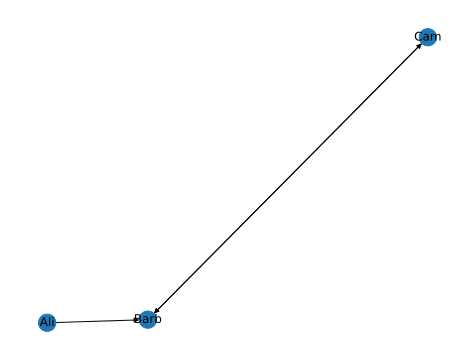

In [12]:
nx.draw_random(g,with_labels=True)

plt.show();

Let's generate a more interesting graph. This is a binomial graph so it looks to every possible edge and creates some realised edges $p$ percent of the time. In this case, it produces edges with a 0.05 percent possiblility. Notable even with such a sparse set of connections the graph should be mostly if not entirely connected. Change the seed value and explore for yourself. Do you see separate components when we change the seed? What about if we raise p? What happens if 20% of possible edges are realised? 

In [15]:
g = nx.generators.binomial_graph(50,.05,seed=1979)
print(g)

Graph with 50 nodes and 60 edges


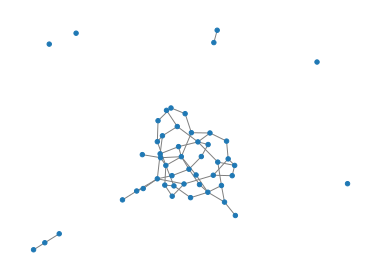

In [16]:
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g,pos,node_size=20)
nx.draw_networkx_edges(g,pos,edge_color="grey")
plt.axis("off")
plt.show()

The groups nodes that connected are called _components_. The biggest one is called the _largest connected component_ or the 'giant component' (though strictly speaking its only the giant component if it contains >50% of nodes). If we filter down to the largest connected component we can see some details more clearly. 

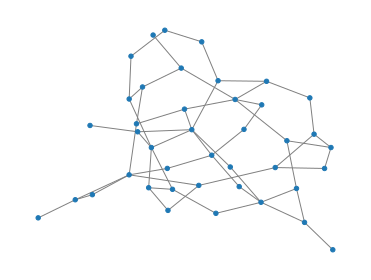

In [17]:
largest_comp_nodes = max(sorted(nx.connected_components(g),
                                key=len, reverse=True))

lcc = g.subgraph(largest_comp_nodes)

nx.draw_networkx_nodes(lcc,pos,node_size=20)
nx.draw_networkx_edges(lcc,pos,edge_color="grey")
plt.axis("off")
plt.show()

# Community detection 

Community detection is an approach to partitioning a graph. It works in some senses like k-means in that it is inductive. There are many, many algorithms for community detection. Some of the most advanced techniques include InfoMap and the Leiden. However, we are using a tried and tested method, Louvain community detection. This approach cited in FSSTDS as Blondel et al., It is included in networkx (finally). 

We will apply this to the Zachary's Karate Club. This was a curious network studied by an anthropologist. People gave peer nominations among the club. Not long after the anthropologist left, the Karate club split and it seems that the split follows the network structure closely. Thus, it's been a bit of an exemplar data set much like `iris`. It's packaged with `networkx`.  We will plot the actual split between what the researchers call the 'Officer' club and the 'Mr. Hi' club. We can then use community detection to infer the split. 

When we use community detection we typically use 'modularity' ($Q$) as a goodness of fit metric. There is no p-value for modularity but there are lots of advanced estimation techniques. Here we will use the following guidance instead: $Q>0.3$ means generally distinct communities. Notice the modularity score for this network. 

We can also use the same sort of classification metrics we did before. It would follow the k-means approach where we match the community with the majority ground truth group and look at accuracy scores. 

In [3]:
kg = nx.karate_club_graph()
print(kg)

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


Notice how we report on the number of members in each club. The 'club' is an attribute of the network. 

In [6]:
from collections import defaultdict

clubs = defaultdict(list)

for node in kg.nodes: 
    clubs[kg.nodes[node]["club"]].append(node)

for club, members in clubs.items(): 
    print(f"Club {club} has {len(members)} members") 

Club Mr. Hi has 17 members
Club Officer has 17 members


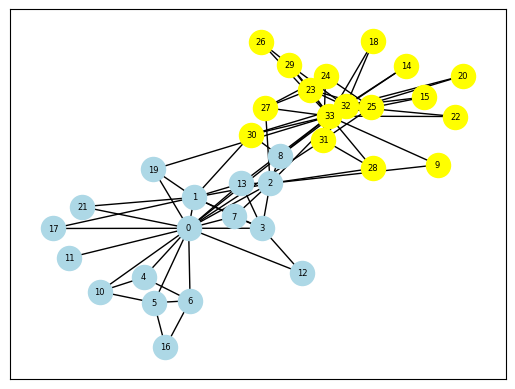

In [10]:
pos = nx.spring_layout(kg, iterations=100)

nx.draw_networkx_nodes(kg.subgraph(clubs["Mr. Hi"]), pos,
                      node_color="lightblue")

nx.draw_networkx_nodes(kg.subgraph(clubs["Officer"]), pos,
                      node_color="yellow")

nx.draw_networkx_edges(kg,pos)

nx.draw_networkx_labels(kg,pos,
                        font_size=6)
plt.show()

The network we see is an example of 'ground truth'. However we can also try to infer the community structure. We can plot these side by side. 

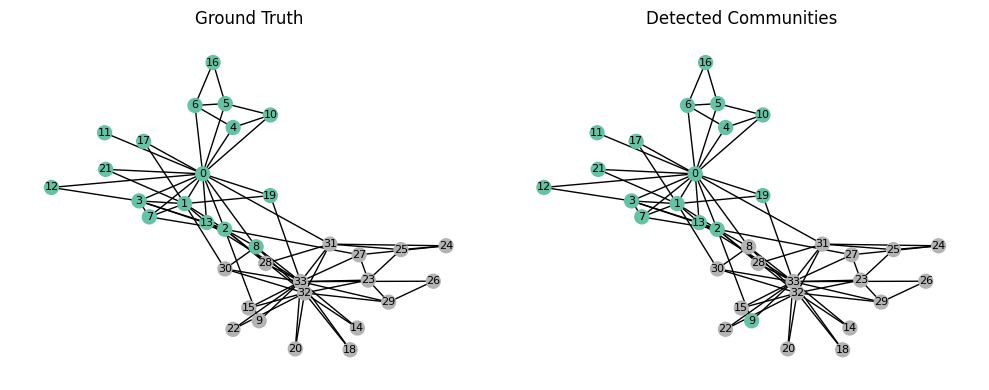

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt

# Create Karate Club graph
kg = nx.karate_club_graph()
pos = nx.spring_layout(kg, seed=42)  # Same layout for both plots

# Get ground truth (instructor vs administrator)
ground_truth = [0 if kg.nodes[node]['club'] == 'Mr. Hi' else 1 
                for node in kg.nodes()]

# Get community detection results
greedy_comm = list(nx.community.greedy_modularity_communities(kg, resolution=0.8))
comm_dict = {}
for idx, comm in enumerate(greedy_comm):
    for node in comm:
        comm_dict[node] = idx

detected = [comm_dict[node] for node in sorted(kg.nodes())]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Ground Truth
nx.draw(kg, pos, node_color=ground_truth, ax=ax1, 
        node_size=100, cmap=plt.cm.Set2, 
        with_labels=True, font_size=8)
ax1.set_title('Ground Truth')

# Detected Communities
nx.draw(kg, pos, node_color=detected, ax=ax2, 
        node_size=100, cmap=plt.cm.Set2, 
        with_labels=True, font_size=8)
ax2.set_title('Detected Communities')

plt.tight_layout()
plt.show()

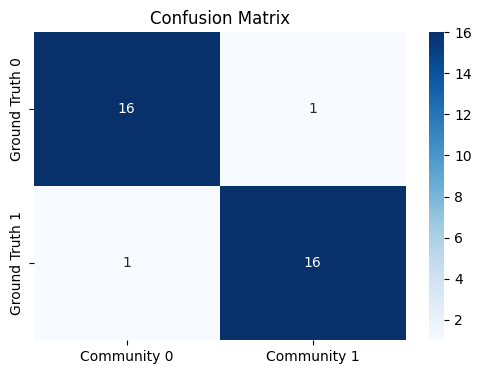


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.94      0.94      0.94        17

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate metrics
conf_matrix = confusion_matrix(ground_truth, detected)
report = classification_report(ground_truth, detected)

# Add confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Community 0', 'Community 1'],
            yticklabels=['Ground Truth 0', 'Ground Truth 1'])
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(report)

# Building networks. 

If you run the lab, you will see how we can build three different kinds of networks with reddit comment data. The lab will describe these (threaded comments, user-interaction network, bipartite (user to post network)). Your goal is once again to apply this code to your subreddits of choice and to explore the results. 

There is great depth that you can explore with networks and of course we are only scratching the surface. But even with simple community detection we can start to explore some fascinating issues. The bipartite network is not fully fleshed out. You can explore 'bipartite projection' or 'two-model' network analysis to see deeper examples with this way of structuring data. Similarly, we do not do any interesting analytics with the threaded comments but you could explore thread depth or width to describe a subreddit or a post. 

# Friday's class 

For the last class, I will be giving a presentation on visual machine learning with Stable Diffusion. I will use this lecture to introduce embeddings using CLIP and to visually illustrate with different generated images in stable diffusion how we might think about how a vector for a term makes a difference to the overall image. This will be less as a specific tool for you to apply in your own work and summative and more of a means for you to understand beyond some basic text classification why terms as vectors. There is no specific reading for this class as descriptions about Stable Diffusion (and diffusion models in general) vary hugely widely. 

You are welcome to consider videos introducing this topic. To note, on account of the ability to generate synthetic people there appears to be considerable interest in tutorials in representing 'attractive' people and particularly women. This might create a distored picture of these model's capacities and strengths (as opposed to the priorities of the authors of these guides). The tutorial at https://stable-diffusion-art.com/beginners-guide/ is such an example. It is in fact a very clear beginner tutorial but the subject matter (and this site tends to have clear up-to-date tutorials). However, it also includes synthetic subjects who might belong in a fashion magazine rather than a documentary cross section of people. 

The lecture will be using the likeness of the instructor and some prototypical subjects like cats and dogs (and interesting cat-dog blends that still somehow look realistic but illustrate how vector semantics can play out in the interesting space of AI models). These models must first encode text and then generate images that steer towards that text. This encoding turns text into vectors, albeit more complex than the vectors of TF-IDF. Thus we can use this to extend outwards to how we might locate some text in a wider language space than one created just from our documents. 

# AI Declaration 

This lecture used co-pilot with Claude Sonnet 3.5 (new) for some code snippets. It was used extensively to generate ideas but most of the code was drawn from "From Social Science to Data Science". It was used more heavily in the lab, however, these tools tend to be a bit clumsy across files. I would instead generate a single set of tasks and then reassemble the pieces myself in different places. It was useful to ask copilot what it thought would be best for refactoring. Some comments were cleaned up. The object model for the RedditScraper needed considerable work. 